In [1]:
from __future__ import print_function
import glob
from itertools import chain
import os
import cv2
import csv
import random
import zipfile
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from functools import reduce
import torch.nn as nn
from einops import rearrange, repeat
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import ToPILImage
# from linformer import Linformer
from PIL import Image
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
# from vit_pytorch.efficient import ViT
# from model import BiSeNet
import torchvision.transforms as transforms
from skimage import io, img_as_float
import timm

In [2]:
# FOR XCIT 
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [3]:
seed = 17
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [4]:
train_dir_real = '../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/train_set_real/'
train_dir_faceswap_fake = '../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/train_set_faceswap_fake/'
train_dir_deepfakes_fake = '../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/train_set_deepfakes_fake/'
train_dir_face2face_fake = '../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/train_set_face2face_fake/'
train_dir_neuraltextures_fake = '../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/train_set_neuraltextures_fake/'

validation_dir_real = '../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/validation_set_real/'
validation_dir_faceswap_fake = '../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/validation_set_faceswap_fake/'
validation_dir_deepfakes_fake = '../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/validation_set_deepfakes_fake/'
validation_dir_face2face_fake = '../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/validation_set_face2face_fake/'
validation_dir_neuraltextures_fake = '../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/validation_set_neuraltextures_fake/'

In [5]:
train_list_real = glob.glob(os.path.join(train_dir_real,'*'))
train_list_faceswap_fake = glob.glob(os.path.join(train_dir_faceswap_fake,'*'))
train_list_deepfakes_fake = glob.glob(os.path.join(train_dir_deepfakes_fake,'*'))
train_list_face2face_fake = glob.glob(os.path.join(train_dir_face2face_fake,'*'))
train_list_neuraltextures_fake = glob.glob(os.path.join(train_dir_neuraltextures_fake,'*'))

validation_list_real = glob.glob(os.path.join(validation_dir_real,'*'))
validation_list_faceswap_fake = glob.glob(os.path.join(validation_dir_faceswap_fake,'*'))
validation_list_deepfakes_fake = glob.glob(os.path.join(validation_dir_deepfakes_fake,'*'))
validation_list_face2face_fake = glob.glob(os.path.join(validation_dir_face2face_fake,'*'))
validation_list_neuraltextures_fake = glob.glob(os.path.join(validation_dir_neuraltextures_fake,'*'))



In [6]:
train_list_real = [path.replace('\\','/') for path in train_list_real]
train_list_faceswap_fake = [path.replace('\\','/') for path in train_list_faceswap_fake]
train_list_deepfakes_fake = [path.replace('\\','/') for path in train_list_deepfakes_fake]
train_list_face2face_fake = [path.replace('\\','/') for path in train_list_face2face_fake]
train_list_neuraltextures_fake = [path.replace('\\','/') for path in train_list_neuraltextures_fake]

validation_list_real = [path.replace('\\','/') for path in validation_list_real]
validation_list_faceswap_fake = [path.replace('\\','/') for path in validation_list_faceswap_fake]
validation_list_deepfakes_fake = [path.replace('\\','/') for path in validation_list_deepfakes_fake]
validation_list_face2face_fake = [path.replace('\\','/') for path in validation_list_face2face_fake]
validation_list_neuraltextures_fake = [path.replace('\\','/') for path in validation_list_neuraltextures_fake]

In [7]:
all_fake_train_list = []
all_fake_train_list.extend(train_list_faceswap_fake)
all_fake_train_list.extend(train_list_deepfakes_fake)
all_fake_train_list.extend(train_list_face2face_fake)
all_fake_train_list.extend(train_list_neuraltextures_fake)

all_fake_validation_list = []
all_fake_validation_list.extend(validation_list_faceswap_fake)
all_fake_validation_list.extend(validation_list_deepfakes_fake)
all_fake_validation_list.extend(validation_list_face2face_fake)
all_fake_validation_list.extend(validation_list_neuraltextures_fake)

In [8]:
fake_train_images = []
for i in range(len(all_fake_train_list)):
#     print(train_list_real[i])
    j = 0
    for (root, dirs, file) in os.walk(all_fake_train_list[i]):
        for f in file:
            if j < 6:
                fake_train_images.append(all_fake_train_list[i] + '/' + f)
                j+=1
            elif j > 21 and j < 30:
                fake_train_images.append(all_fake_train_list[i] + '/' + f)
                j+=1
                pass
            elif j > 55 and j <= 60:
                fake_train_images.append(all_fake_train_list[j] + '/' + f)
                j+=1
            else:
                j+=1


fake_validation_images = []
for i in range(len(all_fake_validation_list)):
#     print(train_list_real[i])
    j = 0
    for (root, dirs, file) in os.walk(all_fake_validation_list[i]):
        for f in file:
            if j < 6:
                fake_validation_images.append(all_fake_validation_list[i] + '/' + f)
                j+=1
            elif j > 22 and j < 30:
                fake_validation_images.append(all_fake_validation_list[i] + '/' + f)
                j+=1
                pass
            elif j > 55 and j <= 60:
                fake_validation_images.append(all_fake_validation_list[j] + '/' + f)
                j+=1
            else:
                j+=1

In [9]:
len(fake_validation_images)

10080

In [10]:
np.random.shuffle(fake_train_images)                
np.random.shuffle(fake_train_images)                
np.random.shuffle(fake_train_images)                

np.random.shuffle(fake_validation_images)                
np.random.shuffle(fake_validation_images)                
np.random.shuffle(fake_validation_images)

In [11]:
all_training_images = []

for i in range(len(train_list_real)):
#     print(train_list_real[i])
    for (root, dirs, file) in os.walk(train_list_real[i]):
        for f in file:
            if '.png' in f and 'mel' not in f and 'mfccs' not in f:
                all_training_images.append(train_list_real[i] + '/' + f)

np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)                
np.random.shuffle(all_training_images)                

all_training_images = all_training_images[:50000]
len(all_training_images)                
                
# for i in range(50000):
# #     print(train_list_real[i])
#     for (root, dirs, file) in os.walk(train_list_fake[i]):
#         for f in file:
#             if '.png' in f and 'mel' not in f and 'mfccs' not in f:
#                 all_training_images.append(train_list_fake[i] + '/' + f)

50000

In [12]:
all_training_images.extend(fake_train_images[:50000])
len(all_training_images)                


100000

In [13]:
all_validation_images = []

for i in range(len(validation_list_real)):
#     print(train_list_real[i])
    for (root, dirs, file) in os.walk(validation_list_real[i]):
        for f in file:
            if '.png' in f and 'mel' not in f and 'mfccs' not in f:
                all_validation_images.append(validation_list_real[i] + '/' + f)

np.random.shuffle(all_validation_images)                
np.random.shuffle(all_validation_images)                
np.random.shuffle(all_validation_images)                


all_validation_images = all_validation_images[:10000]
len(all_validation_images)


all_validation_images.extend(fake_validation_images[:10000])
len(all_validation_images)

20000

In [14]:
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)
np.random.shuffle(all_training_images)

np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)
np.random.shuffle(all_validation_images)

In [15]:
# all_training_images = all_training_images[:5000]
# all_validation_images = all_validation_images[:1000]


In [16]:
print(f"Training Data: {len(all_training_images)}")
# print(f"Train Data Fake: {len(train_list_fake)}")
print('***********************************')
print('***********************************')
print(f"Validation Data: {len(all_validation_images)}")
# print(f"Validation Data Fake: {len(valid_list_fake)}")

Training Data: 100000
***********************************
***********************************
Validation Data: 20000


In [17]:
labels = [path.split('/')[-3].split('_')[-1] for path in all_training_images]
print(labels[:10])

['real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real']


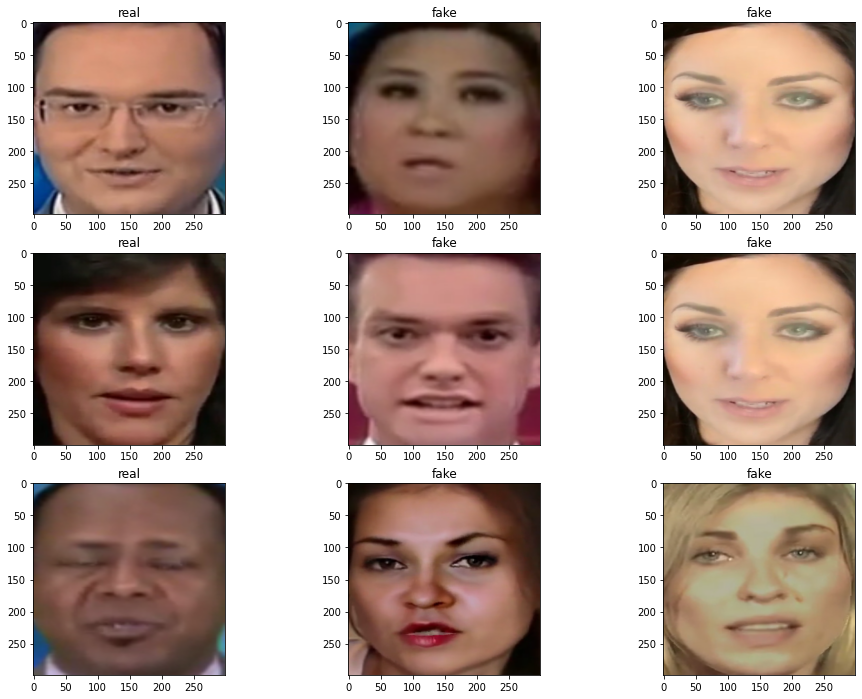

In [18]:
random_idx = np.random.randint(1, len(all_training_images), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
#     frames = sorted(glob.glob(train_list[idx] +'/*.png'))
#     frame = frames[0]
    img = Image.open(all_training_images[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [19]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
        iaa.Resize((224, 224)),
#         iaa.Crop(px=(0, 16)),
        iaa.Fliplr(0.5), # horizontally flip
        iaa.OneOf([
            iaa.Affine(scale=1.5),
            iaa.Affine(rotate=20),
            iaa.Affine(translate_px=(-20, 20)),
            iaa.Cutout(fill_mode="constant", cval=0, nb_iterations=2, size=0.4)
        ]),
#         iaa.OneOf([
#             iaa.JpegCompression(compression=(60, 70)),
#             iaa.GaussianBlur((0, 1.0)),
#             iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.3),
#             iaa.Multiply((0.5, 1.0), per_channel=0.2),
#             iaa.Cutout(fill_mode="constant", cval=0, nb_iterations=1, size=0.5)
#                 ])
        ], random_order=True)
      
    def __call__(self, img):
        img = np.array(img).astype(np.uint8)
        img = self.aug.augment_image(img)
        img = torchvision.transforms.ToTensor()(img)
        img = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)
        return img
transforms_imgaug = ImgAugTransform()

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [20]:
import cv2
import dlib
from imutils import face_utils
import imutils
import numpy as np
import torch

def face_remap(shape):
    remapped_image = cv2.convexHull(shape)
    return remapped_image

def augment_face(detector, predictor, img, random_num):
    frame = cv2.imread(img)
#     frame = img
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    out_face = np.zeros_like(frame)
    # out_face = frame
    faces = detector(gray, 1) 
    if not faces:
        pass
    else:
        for face in faces:
            landmarks = predictor(gray, face)
            shape = face_utils.shape_to_np(landmarks)
            remapped_shape = np.zeros_like(shape) 
            feature_mask = np.zeros((frame.shape[0], frame.shape[1]))

        #Lower face
        if random_num == 1:
            remapped_shape = face_remap(shape[1:12])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[3:14])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[6:17])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Eyes and Mouth
        if random_num == 2:
            remapped_shape = face_remap(shape[37:42])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[43:48])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Eyes, Mouth and Nose
        elif random_num == 3:
            remapped_shape = face_remap(shape[28:36])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[37:42])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[43:48])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Lower left side of face
        elif random_num == 4:
            remapped_shape = face_remap(shape[1:12])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Lower right side of face
        elif random_num == 5:
            remapped_shape = face_remap(shape[6:17])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Nose and Mouth
        elif random_num == 6:
            remapped_shape = face_remap(shape[28:36])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        #Mouth
        elif random_num == 7:
            remapped_shape = face_remap(shape[49:68])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)

        # Eyes and Nose
        elif random_num == 8:
            remapped_shape = face_remap(shape[37:42])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[43:48])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
            remapped_shape = face_remap(shape[28:46])
            cv2.fillConvexPoly(feature_mask, remapped_shape, 1)
        
        
        feature_mask = feature_mask.astype(np.bool)
        out_face[feature_mask] = frame[feature_mask]
        frame = frame - out_face
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         cv2.imwrite("out_face.png", frame)
    
    return frame

In [21]:
class DeepFakeSet(Dataset):
    def __init__(self, file_list, transform=None):

        self.file_list = file_list
        self.transform = transform
        self.to_img = ToPILImage()
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("FaceExtraction/shape_predictor_81_face_landmarks.dat")

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
#         random_num = torch.randint(1, 12, (1,))
#         augmented_face = augment_face(self.detector, self.predictor, img_path, random_num)
#         img_transformed = self.transform(self.to_img(augmented_face))
        img_transformed = self.transform(img)

        label = img_path.split('/')[-3].split('_')[-1]
#         print(label)
        label = 1 if label == "real" else 0
    
        return img_transformed, label

In [22]:
train_data = DeepFakeSet(all_training_images, transform=transforms_imgaug)
valid_data = DeepFakeSet(all_validation_images, transform=val_transforms)

batch_size = 16

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)

print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

100000 6250
20000 1250


In [23]:
device = 'cuda'
# device = 'cpu'

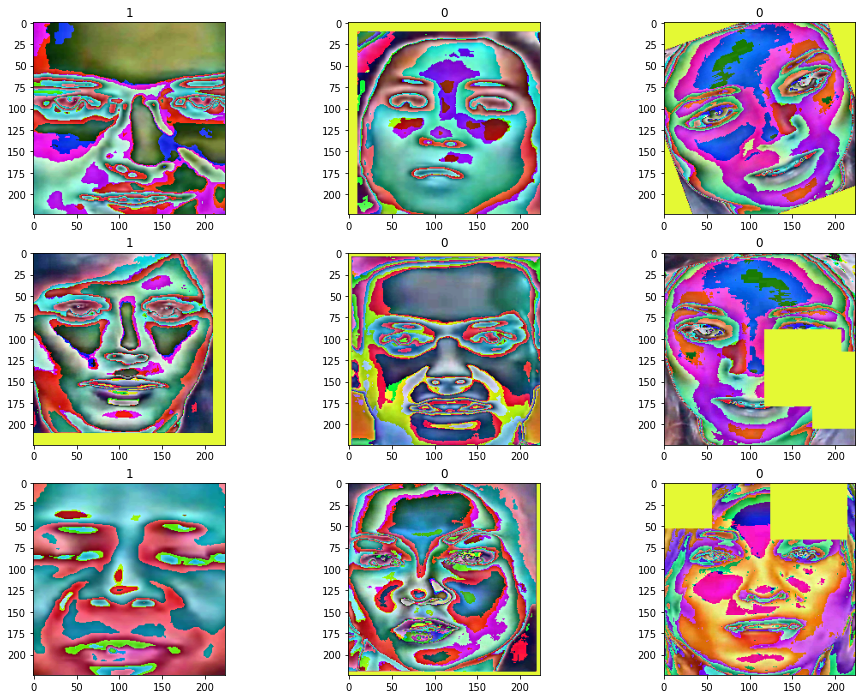

In [24]:
to_img = ToPILImage()

random_idx = np.random.randint(1, len(train_data), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = (to_img(train_data[idx][0]))
    ax.set_title(train_data[idx][1])
    ax.imshow(img)

In [25]:
import timm
models = ['tf_efficientnet_b7_ns', 'vit_base_patch16_224', 'swin_base_patch4_window7_224', 'mvitv2_base']
# models = ['xception', 'res2net101_26w_4s', 'tf_efficientnet_b7_ns', 'vit_base_patch16_224', 'swin_base_patch4_window7_224', 'mvitv2_base']

augs = ['No_Augmentations', 'Random_Cut_Out_Augs', 'Face_Cut_Out_Augs']
datasets = ['FakeAVCeleb', 'FaceForensics', 'DFDC', 'ForgeryNet']


In [26]:
# CutOut Augs
for model in models:
    
    print("==========================================================================")
    print("==========================================================================")
    print("Training " + model + " on " + datasets[1])
    net = timm.create_model(model, pretrained=True, num_classes=2).to(device)
    epochs = 5
    lr = 3e-3
    # gamma = 0.7

    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_accuracies = []
    train_losses = []

    validation_accuracies = []
    validation_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            
            output = net(data)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_accuracies.append(epoch_accuracy.detach())
        train_losses.append(epoch_loss.detach())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in tqdm(valid_loader):
                data = data.to(device)
                label = label.to(device)
    #             print(data.shape)aa
                val_output = net(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

            validation_accuracies.append(epoch_val_accuracy.detach())
            validation_losses.append(epoch_val_loss.detach())
        
        folder_path = ("model_weights/supervised_models/" + model + "/" + augs[1] + '/' + datasets[1] + '/')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        if epoch == 0:
            PATH = (folder_path + str(epoch+1) + "_epochs.pth")
            torch.save(net.state_dict(), PATH)
        elif epoch > 0:
            if validation_losses[epoch-1] < validation_losses[epoch]:
                pass
            else:
                old_weights_file = (folder_path + str(epoch) + "_epochs.pth")
                if os.path.isfile(old_weights_file):
                    os.remove(old_weights_file)
                else:
                    pass
                PATH = (folder_path + str(epoch+1) + "_epochs.pth")
                torch.save(net.state_dict(), PATH)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        torch.cuda.empty_cache()
        
        
    with open(folder_path + 'results.csv', 'w') as csvfile:
        fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

        writer.writeheader()
        for i in range(len(validation_accuracies)):
            writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})
            
    print("==========================================================================")
    print("==========================================================================")
    
    

Training tf_efficientnet_b7_ns on FaceForensics


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.3748 - acc: 0.8337 - val_loss : 0.2743 - val_acc: 0.8901



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1963 - acc: 0.9203 - val_loss : 0.2238 - val_acc: 0.9160



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.1482 - acc: 0.9406 - val_loss : 0.2089 - val_acc: 0.9244



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.1205 - acc: 0.9527 - val_loss : 0.2039 - val_acc: 0.9275



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0993 - acc: 0.9604 - val_loss : 0.2030 - val_acc: 0.9298

Training vit_base_patch16_224 on FaceForensics


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.5876 - acc: 0.6815 - val_loss : 0.4823 - val_acc: 0.7478



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.2451 - acc: 0.8942 - val_loss : 0.2633 - val_acc: 0.9008



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.1357 - acc: 0.9441 - val_loss : 0.2561 - val_acc: 0.8986



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0954 - acc: 0.9620 - val_loss : 0.1990 - val_acc: 0.9256



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0751 - acc: 0.9703 - val_loss : 0.2038 - val_acc: 0.9323

Training swin_base_patch4_window7_224 on FaceForensics


C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.3785 - acc: 0.8115 - val_loss : 0.1760 - val_acc: 0.9307



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1618 - acc: 0.9346 - val_loss : 0.1179 - val_acc: 0.9561



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.1156 - acc: 0.9547 - val_loss : 0.1200 - val_acc: 0.9526



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0959 - acc: 0.9627 - val_loss : 0.2294 - val_acc: 0.9153



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0837 - acc: 0.9680 - val_loss : 0.1156 - val_acc: 0.9565

Training mvitv2_base on FaceForensics


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2427 - acc: 0.8946 - val_loss : 0.1422 - val_acc: 0.9460



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1204 - acc: 0.9525 - val_loss : 0.2034 - val_acc: 0.9171



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0923 - acc: 0.9640 - val_loss : 0.1522 - val_acc: 0.9475



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0761 - acc: 0.9704 - val_loss : 0.1130 - val_acc: 0.9589



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0645 - acc: 0.9748 - val_loss : 0.1291 - val_acc: 0.9537



In [26]:
# No Augs
for model in models:
    
    print("==========================================================================")
    print("==========================================================================")
    print("Training " + model + " on " + datasets[1])
    net = timm.create_model(model, pretrained=True, num_classes=2).to(device)
    epochs = 5
    lr = 3e-3
    # gamma = 0.7

    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_accuracies = []
    train_losses = []

    validation_accuracies = []
    validation_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            
            output = net(data)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_accuracies.append(epoch_accuracy.detach())
        train_losses.append(epoch_loss.detach())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in tqdm(valid_loader):
                data = data.to(device)
                label = label.to(device)
    #             print(data.shape)aa
                val_output = net(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

            validation_accuracies.append(epoch_val_accuracy.detach())
            validation_losses.append(epoch_val_loss.detach())
        
        folder_path = ("model_weights/supervised_models/" + model + "/" + augs[1] + '/' + datasets[1] + '/')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        if epoch == 0:
            PATH = (folder_path + str(epoch+1) + "_epochs.pth")
            torch.save(net.state_dict(), PATH)
        elif epoch > 0:
            if validation_losses[epoch-1] < validation_losses[epoch]:
                pass
            else:
                old_weights_file = (folder_path + str(epoch) + "_epochs.pth")
                if os.path.isfile(old_weights_file):
                    os.remove(old_weights_file)
                else:
                    pass
                PATH = (folder_path + str(epoch+1) + "_epochs.pth")
                torch.save(net.state_dict(), PATH)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        torch.cuda.empty_cache()
        
        
    with open(folder_path + 'results.csv', 'w') as csvfile:
        fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

        writer.writeheader()
        for i in range(len(validation_accuracies)):
            writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})
            
    print("==========================================================================")
    print("==========================================================================")
    
    

Training xception on FaceForensics


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.4439 - acc: 0.7749 - val_loss : 0.2906 - val_acc: 0.8825



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.2457 - acc: 0.8968 - val_loss : 0.2429 - val_acc: 0.9065



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.1949 - acc: 0.9207 - val_loss : 0.2199 - val_acc: 0.9148



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.1663 - acc: 0.9326 - val_loss : 0.2170 - val_acc: 0.9188



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.1447 - acc: 0.9418 - val_loss : 0.2079 - val_acc: 0.9247

Training res2net101_26w_4s on FaceForensics


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2806 - acc: 0.8725 - val_loss : 0.2410 - val_acc: 0.9071



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1352 - acc: 0.9474 - val_loss : 0.2522 - val_acc: 0.9158



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0954 - acc: 0.9628 - val_loss : 0.2147 - val_acc: 0.9268



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0740 - acc: 0.9715 - val_loss : 0.2427 - val_acc: 0.9291



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0646 - acc: 0.9755 - val_loss : 0.1740 - val_acc: 0.9440

Training tf_efficientnet_b7_ns on FaceForensics


  0%|          | 0/6250 [00:00<?, ?it/s]

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [88]:
# No Augs
for model in models:
    
    print("==========================================================================")
    print("==========================================================================")
    print("Training " + model + " on " + datasets[1])
    net = timm.create_model(model, pretrained=True, num_classes=2).to(device)
    epochs = 5
    lr = 3e-3
    # gamma = 0.7

    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_accuracies = []
    train_losses = []

    validation_accuracies = []
    validation_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            
            output = net(data)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_accuracies.append(epoch_accuracy.detach())
        train_losses.append(epoch_loss.detach())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in tqdm(valid_loader):
                data = data.to(device)
                label = label.to(device)
    #             print(data.shape)aa
                val_output = net(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

            validation_accuracies.append(epoch_val_accuracy.detach())
            validation_losses.append(epoch_val_loss.detach())
        
        folder_path = ("model_weights/supervised_models/" + model + "/" + augs[0] + '/' + datasets[1] + '/')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        if epoch == 0:
            PATH = (folder_path + str(epoch+1) + "_epochs.pth")
            torch.save(net.state_dict(), PATH)
        elif epoch > 0:
            if validation_losses[epoch-1] < validation_losses[epoch]:
                pass
            else:
                old_weights_file = (folder_path + str(epoch) + "_epochs.pth")
                if os.path.isfile(old_weights_file):
                    os.remove(old_weights_file)
                else:
                    pass
                PATH = (folder_path + str(epoch+1) + "_epochs.pth")
                torch.save(net.state_dict(), PATH)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        torch.cuda.empty_cache()
        
        
    with open(folder_path + 'results.csv', 'w') as csvfile:
        fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

        writer.writeheader()
        for i in range(len(validation_accuracies)):
            writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})
            
    print("==========================================================================")
    print("==========================================================================")
    
    

Training xceptionon FaceForensics


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.3335 - acc: 0.8436 - val_loss : 0.2720 - val_acc: 0.8950



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1366 - acc: 0.9471 - val_loss : 0.2556 - val_acc: 0.9056



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0877 - acc: 0.9667 - val_loss : 0.2817 - val_acc: 0.9060



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0617 - acc: 0.9771 - val_loss : 0.2981 - val_acc: 0.9099



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0483 - acc: 0.9823 - val_loss : 0.2900 - val_acc: 0.9121

Training res2net101_26w_4son FaceForensics


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1890 - acc: 0.9198 - val_loss : 0.2142 - val_acc: 0.9234



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0592 - acc: 0.9784 - val_loss : 0.2441 - val_acc: 0.9300



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0336 - acc: 0.9877 - val_loss : 0.2376 - val_acc: 0.9334



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0196 - acc: 0.9928 - val_loss : 0.2551 - val_acc: 0.9358



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0156 - acc: 0.9944 - val_loss : 0.2466 - val_acc: 0.9422

Training tf_efficientnet_b7_nson FaceForensics


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2708 - acc: 0.8839 - val_loss : 0.2853 - val_acc: 0.8938



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0891 - acc: 0.9668 - val_loss : 0.2910 - val_acc: 0.9073



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0522 - acc: 0.9808 - val_loss : 0.3372 - val_acc: 0.9070



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0347 - acc: 0.9878 - val_loss : 0.3384 - val_acc: 0.9126



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0246 - acc: 0.9911 - val_loss : 0.3413 - val_acc: 0.9174

Training vit_base_patch16_224on FaceForensics


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.5333 - acc: 0.7133 - val_loss : 0.5088 - val_acc: 0.7487



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.2099 - acc: 0.9115 - val_loss : 0.2974 - val_acc: 0.8753



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0880 - acc: 0.9651 - val_loss : 0.3607 - val_acc: 0.8594



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0512 - acc: 0.9801 - val_loss : 0.5146 - val_acc: 0.8428



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0330 - acc: 0.9878 - val_loss : 0.4856 - val_acc: 0.8686

Training swin_base_patch4_window7_224on FaceForensics


C:\Users\Sohail\.conda\envs\python_3_gpss\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2856 - acc: 0.8669 - val_loss : 0.1645 - val_acc: 0.9366



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1015 - acc: 0.9609 - val_loss : 0.1566 - val_acc: 0.9434



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0610 - acc: 0.9765 - val_loss : 0.1906 - val_acc: 0.9384



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0469 - acc: 0.9822 - val_loss : 0.1682 - val_acc: 0.9440



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0336 - acc: 0.9869 - val_loss : 0.2049 - val_acc: 0.9411

Training mvitv2_baseon FaceForensics


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1990 - acc: 0.9142 - val_loss : 0.1289 - val_acc: 0.9517



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0734 - acc: 0.9724 - val_loss : 0.1333 - val_acc: 0.9541



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0481 - acc: 0.9821 - val_loss : 0.1476 - val_acc: 0.9541



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0340 - acc: 0.9876 - val_loss : 0.1397 - val_acc: 0.9566



  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0261 - acc: 0.9904 - val_loss : 0.1552 - val_acc: 0.9566



# Evaluate

In [26]:
net.eval()


MultiScaleVit(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  )
  (stages): ModuleList(
    (0): MultiScaleVitStage(
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (pool_q): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False)
            (norm_q): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_k): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_k): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_v): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_v): LayerN

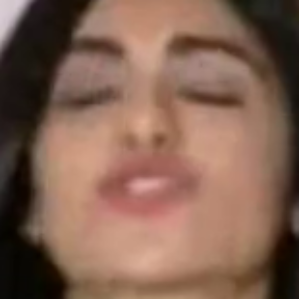

In [33]:
img = Image.open('../Datasets/DeepfakeDetection/FakeAVCeleb_v1_2/Cleaned_Data/Images/test_set_real/id00043/0000.png')
img

In [34]:
tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), 
                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])
img = tfms(img)

In [35]:
labels_map = ["fake", "real"]
# Preprocess image

# Classify

probs = {}
with torch.no_grad():
    outputs = net(img.unsqueeze(0).to(device))
print('-----')
for idx in torch.topk(outputs[0], k=2).indices.tolist():
    prob = torch.softmax(outputs[0], 0)[idx].item()
    probs[idx] = (labels_map[idx], prob*100)
    print((labels_map[idx], prob*100))
#     print('[{idx}] {label:<75} ({p:.2f}%)'.format(idx=idx, label=labels_map[idx], p=prob*100))

-----
('real', 99.99690055847168)
('fake', 0.0030946644983487204)


# Evaluate on Videos

In [5]:
models = ['xception', 'res2net101_26w_4s', 'tf_efficientnet_b7_ns', 'vit_base_patch16_224', 'swin_base_patch4_window7_224', 'mvitv2_base']
net = timm.create_model(models[5], pretrained=True, num_classes=2).to('cuda')
PATH = 'model_weights/supervised_models/mvitv2_base/Random_Cut_Out_Augs/FaceForensics/4_epochs.pth'
net.load_state_dict(torch.load(PATH))

net.eval()

MultiScaleVit(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  )
  (stages): ModuleList(
    (0): MultiScaleVitStage(
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (pool_q): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False)
            (norm_q): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_k): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_k): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_v): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_v): LayerN

In [10]:
videos = sorted(glob.glob('../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/test_set_real/*/'))
videos = [path.replace('\\','/') for path in videos]
len(videos)

140

In [11]:
# model.eval()
labels_map = ["fake", "real"]
count = 0
predictions = {}
probs = {}
for vid in videos:
    count+=1
    print(count)
    fake_prob = 0
    real_prob = 0
#     print(vid)
    images = sorted(glob.glob('../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/test_set_real/'+str(vid.split('/')[-2])+'/*.png'))
    images = [path.replace('\\','/') for path in images]
    if len(images) >= 12:
        images = images[:20]
        for image in images:
            img = Image.open(image)
            tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])
            img = tfms(img)
            with torch.no_grad():
                outputs = net(img.unsqueeze(0).to('cuda'))
            for idx in torch.topk(outputs[0], k=1).indices.tolist():
                prob = torch.softmax(outputs[0], 0)[idx].item()
                if labels_map[idx] == 'fake':
                    fake_prob += prob
                    real_prob += 1-prob
                else:
                    real_prob += prob
                    fake_prob += 1 - prob
        if real_prob > fake_prob:
            predictions[vid.split('/')[-2]] = 1
            probs[vid.split('/')[-2]] = (real_prob/len(images))
            print(image)
            print('real', real_prob/len(images))
        else:
            predictions[vid.split('/')[-2]] = 0
            probs[vid.split('/')[-2]] = 1-(fake_prob/len(images))
#             print(image)
#             print('fake', fake_prob/len(images))
    else:
        pass
    print('--------------')
#     break

1
../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/test_set_real/000/0019.png
real 0.9965493261814118
--------------
2
../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/test_set_real/003/0019.png
real 0.9973328530788421
--------------
3
../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/test_set_real/012/0019.png
real 0.8765018820762634
--------------
4
../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/test_set_real/015/0019.png
real 0.7638482868671417
--------------
5
../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/test_set_real/024/0019.png
real 0.9276318043470383
--------------
6
../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/test_set_real/026/0019.png
real 0.9375905930995941
--------------
7
../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/test_set_real/029/0019.png
real 0.7318823784589767
--------------
8
../Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/test_set_real/035/0019.png
real 0.73011294901371
--------------
9


KeyboardInterrupt: 

# Write results to CSV

In [23]:
with open(folder_path + 'results.csv', 'w') as csvfile:
    fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

    writer.writeheader()
    for i in range(len(validation_accuracies)):
        writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})
    

# Model Parameter Count

In [8]:
models = ['xception', 'res2net101_26w_4s', 'tf_efficientnet_b7_ns', 'vit_base_patch16_224', 'swin_base_patch4_window7_224', 'mvitv2_base']

net = timm.create_model(models[5], pretrained=True, num_classes=2)

In [5]:
# XCEPTION
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

21.0

In [7]:
# Res2Net 101
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

43.0

In [45]:
# Efficient Net B7
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

64.0

In [47]:
# ViT Base
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

86.0

In [49]:
# Swin Base
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

87.0

In [9]:
# MViT Base
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

51.0